# Imports

In [1]:
import pandas as pd
import numpy as np
import gc

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cluster import MeanShift, KMeans

In [3]:
import networkx as nx
from community import community_louvain

# Prepare data

In [4]:
df = pd.read_csv('data/corpus_metaIP.csv').drop(columns = 'Unnamed: 0')
df = df.dropna(subset=['longitude'])
df = df.drop(columns = ['image_direct_url', 'aws_path', 'extracted'])
df.head(1)

,index,date,longitude,latitude,colored,shape_ratio,verticality,horizontality,hue,saturation,value
0,10000979206,2013-09-30 00:26:09.0,14.499968,46.053249,1.0,1.0,12.854769,15.17386,70.0,14.0,56.0


In [5]:
df_users = pd.read_json('focused_metadata.json').reset_index().drop(columns=['level_0'])
df_users = df_users.dropna(subset=['longitude'])
df_users = df_users.drop(columns = ['date', 'longitude', 'latitude', 'camera', 'json_autotags'])
df_users.head(1)

,index,user_identifier,license_name,tag_cluster,external_upload
0,10000979206,66172503@N00,Attribution License,1,instagram


In [6]:
df = pd.merge(df, df_users, on = 'index', how = 'inner')

In [7]:
df.head(1)

,index,date,longitude,latitude,colored,shape_ratio,verticality,horizontality,hue,saturation,value,user_identifier,license_name,tag_cluster,external_upload
0,10000979206,2013-09-30 00:26:09.0,14.499968,46.053249,1.0,1.0,12.854769,15.17386,70.0,14.0,56.0,66172503@N00,Attribution License,1,instagram


In [8]:
sns.set(rc={'figure.figsize':(16,10)})
sns.set_style("ticks")
sns.set_context('notebook', font_scale=1.5)

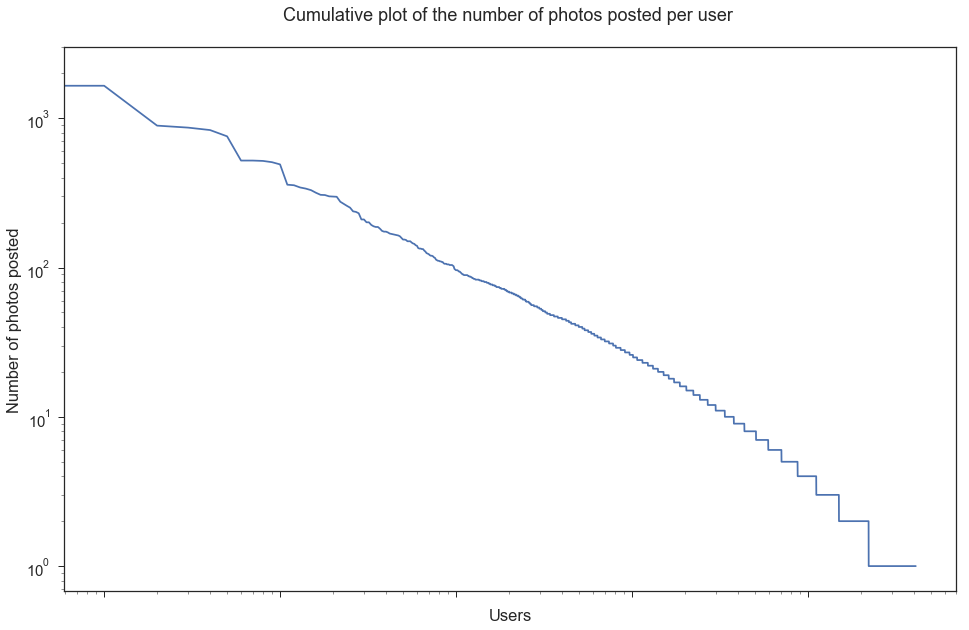

In [9]:
ax = df['user_identifier'].value_counts().plot(logx = True, logy = True, 
                                          title = 'Cumulative plot of the number of photos posted per user \n')
ax.set_xlabel('Users')
ax.set_ylabel('Number of photos posted')
ax;

## Compute network edges

In [10]:
dummies = pd.get_dummies(df[['license_name', 'external_upload']]).rename(
    columns = {'license_name_Attribution License': 'CC BY',
              'license_name_Attribution-NoDerivs License': 'CC BY-ND',
              'license_name_Attribution-NonCommercial License': 'CC BY-NC',
              'license_name_Attribution-NonCommercial-NoDerivs License': 'CC BY-ND-NC',
              'license_name_Attribution-NonCommercial-ShareAlike License': 'CC BY-NC-SA',
              'license_name_Attribution-ShareAlike License': 'CC BY-SA'})

In [11]:
dummies['ND'] = dummies['CC BY-ND'] + dummies['CC BY-ND-NC']
dummies['NC'] = dummies['CC BY-NC'] + dummies['CC BY-ND-NC'] + dummies['CC BY-NC-SA']
dummies['SA'] = dummies['CC BY-NC-SA'] + dummies['CC BY-SA']

In [12]:
dummies = dummies.drop(columns = ['CC BY', 'CC BY-ND', 'CC BY-NC', 'CC BY-SA', 'CC BY-ND-NC', 'CC BY-NC-SA'])

In [13]:
dummies = dummies.reset_index()

In [14]:
trends = pd.get_dummies(df['tag_cluster']).rename(
    columns = {0: 'trend_0', 1: 'trend_1', 2: 'trend_2', 3: 'trend_3', 4: 'trend_4'})

In [15]:
trends = trends.reset_index()

In [16]:
dummies = pd.merge(dummies, trends, on ='index')

In [17]:
dummies.head(1)

,index,external_upload_astrometrydotnet,external_upload_camera,external_upload_dopplr,external_upload_flickrandroidapp,external_upload_flickriosapp,external_upload_foursquare,external_upload_geo,external_upload_geocode,external_upload_http,...,external_upload_lastfm,external_upload_taxonomy,ND,NC,SA,trend_0,trend_1,trend_2,trend_3,trend_4
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [18]:
df = df.drop(columns = 'index').reset_index()
df = pd.merge(df, dummies, on = 'index').drop(columns = 'index')
df = df.drop(columns = ['date', 'license_name', 'tag_cluster', 'external_upload'])
df.head(1)

,longitude,latitude,colored,shape_ratio,verticality,horizontality,hue,saturation,value,user_identifier,...,external_upload_lastfm,external_upload_taxonomy,ND,NC,SA,trend_0,trend_1,trend_2,trend_3,trend_4
0,14.499968,46.053249,1.0,1.0,12.854769,15.17386,70.0,14.0,56.0,66172503@N00,...,0,0,0,0,0,0,1,0,0,0


In [19]:
df = df.drop(columns = ['external_upload_astrometrydotnet', 'external_upload_camera',
                       'external_upload_dopplr', 'external_upload_foursquare', 'external_upload_geo',
                       'external_upload_http', 'external_upload_geocode', 'external_upload_lastfm'])

In [20]:
users = df['user_identifier'].value_counts()
print(len(users))
print(len(users[users >= 3]))

41091
15017


In [40]:
groupby_user = df.groupby(by = 'user_identifier').mean()

In [41]:
groupby_user = groupby_user.iloc[users[users >= 20]]

In [42]:
len(groupby_user)

1514

In [43]:
# Normalize

for col in groupby_user.columns:  
    groupby_user[col] = (groupby_user[col] - groupby_user[col].min())/(
        groupby_user[col].max() - groupby_user[col].min())

In [44]:
groupby_user = groupby_user.drop(columns = 'colored')

In [48]:
len(groupby_user)

1500

In [47]:
groupby_user = groupby_user.dropna()

In [50]:
def compute_user_distance(groupby_user, subset = ''):
    
    array = np.zeros((len(groupby_user), len(groupby_user)))
    done = np.zeros((len(groupby_user), len(groupby_user)))
    
    if subset != '':
        feat = groupby_user[subset]
    else:
        feat = groupby_user
    
    feat = feat.reset_index().drop(columns = 'user_identifier')
    
    for ind_1, user_1 in feat.iterrows():
        for ind_2, user_2 in feat.iterrows():
            if (done[ind_2, ind_1] == 0) & (ind_1 != ind_2):
                score = 1e-3
                for col in feat.columns:
                    score += (user_1[col] - user_2[col])**2
                if score < 1:
                    array[ind_1, ind_2] = 1/score
                done[ind_1, ind_2] = 1
            
    return array

In [51]:
groupby_user.columns

Index(['longitude', 'latitude', 'shape_ratio', 'verticality', 'horizontality',
       'hue', 'saturation', 'value', 'external_upload_flickrandroidapp',
       'external_upload_flickriosapp', 'external_upload_instagram',
       'external_upload_taxonomy', 'ND', 'NC', 'SA', 'trend_0', 'trend_1',
       'trend_2', 'trend_3', 'trend_4'],
      dtype='object')

In [52]:
len(groupby_user)

1500

In [53]:
gc.collect()

7

In [54]:
pd.Series(groupby_user.index).to_json('networks/index_small.json')

In [55]:
gc.collect()

0

In [56]:
location = compute_user_distance(groupby_user, subset = ['longitude', 'latitude'])
location = pd.DataFrame(location)
location.to_csv('networks/location_small.csv')

In [57]:
gc.collect()

28

In [58]:
cc = compute_user_distance(groupby_user, subset = ['ND', 'NC', 'SA'])
cc = pd.DataFrame(cc)
cc.to_csv('networks/cc_small.csv')

In [59]:
gc.collect()

28

In [60]:
trends = compute_user_distance(groupby_user, subset = ['trend_0', 'trend_1',
                                                               'trend_2', 'trend_3', 'trend_4'])
trends = pd.DataFrame(trends)
trends.to_csv('networks/trends_small.csv')

In [61]:
gc.collect()

35

In [62]:
image = compute_user_distance(groupby_user, subset = ['shape_ratio', 'verticality', 'horizontality',
       'hue', 'saturation', 'value'])
image = pd.DataFrame(image)
image.to_csv('networks/image_small.csv')

In [63]:
gc.collect()

28

In [64]:
upload = compute_user_distance(groupby_user, subset = ['external_upload_flickrandroidapp',
       'external_upload_flickriosapp', 'external_upload_instagram'])
upload = pd.DataFrame(upload)
upload.to_csv('networks/upload_small.csv')

In [65]:
gc.collect()

28

# Networks analysis

In [103]:
def graph_analysis(file, threshold = 0):
    
    network = pd.read_csv('networks/' + file).drop(columns = 'Unnamed: 0')
    network = network.astype('int')
    network[network < threshold] = 0

    G = nx.Graph()

    list_edges = []

    for col in network.columns:
        for ind, item in network[col].iteritems():
            if item > 0:
                list_edges.append((ind, int(col), item))

    G.add_weighted_edges_from(list_edges)

    print(nx.info(G))

    print("Network sparsity: %.4f" %nx.density(G))

    print('Fully connected graph:', nx.is_connected(G))
    comp = list(nx.connected_components(G))
    print('The graph contains', len(comp), 'connected components')
    
    return G

In [133]:
def advanced_analysis(graph):
    
    print('Transitivity:', '%.3f'%nx.transitivity(graph))
    
    comp = list(nx.connected_components(graph))
    largest_comp = max(comp, key=len)
    percentage_lcc = len(largest_comp)/ graph.number_of_nodes() * 100
    print('The largest component has ', len(largest_comp), 'nodes', 'accounting for %.2f'% percentage_lcc, '% of the nodes')
    
    betweenness = nx.betweenness_centrality(graph)
    ax = pd.Series(betweenness).sort_values(ascending = False).reset_index().drop(
    columns = 'index').rename(columns = {0: 'Users'}).plot(logx=True, logy=True)
    ax.set_xlabel('Nodes')
    ax.set_ylabel('Betweenness centrality')
    ax  

## Platform network

In [108]:
trends = graph_analysis('trends_small.csv', threshold = 5)

Name: 
Type: Graph
Number of nodes: 1500
Number of edges: 162882
Average degree: 217.1760
Network sparsity: 0.1449
Fully connected graph: False
The graph contains 2 connected components


In [107]:
image = graph_analysis('image_small.csv', threshold = 5)

Name: 
Type: Graph
Number of nodes: 1495
Number of edges: 191201
Average degree: 255.7873
Network sparsity: 0.1712
Fully connected graph: False
The graph contains 2 connected components


In [105]:
cc = graph_analysis('cc_small.csv', threshold = 5)

Name: 
Type: Graph
Number of nodes: 1499
Number of edges: 225453
Average degree: 300.8045
Network sparsity: 0.2008
Fully connected graph: False
The graph contains 6 connected components


In [106]:
location = graph_analysis('location_small.csv', threshold = 5)

Name: 
Type: Graph
Number of nodes: 1500
Number of edges: 861983
Average degree: 1149.3107
Network sparsity: 0.7667
Fully connected graph: True
The graph contains 1 connected components


In [104]:
upload = graph_analysis('upload_small.csv', threshold = 5)

Name: 
Type: Graph
Number of nodes: 1500
Number of edges: 919678
Average degree: 1226.2373
Network sparsity: 0.8180
Fully connected graph: False
The graph contains 5 connected components


Transitivity: 0.949
The largest component has  1492 nodes accounting for 99.47 % of the nodes


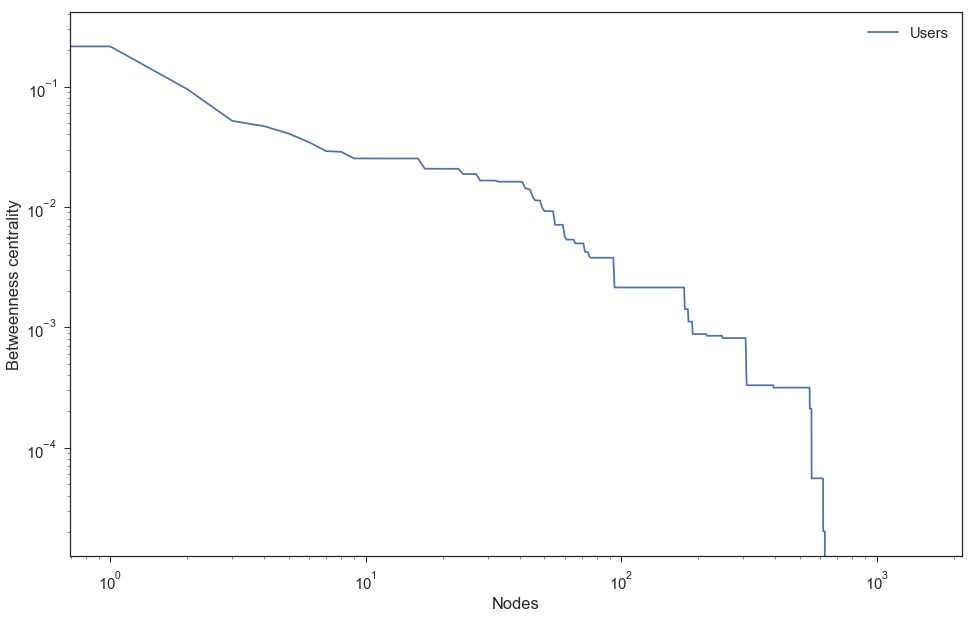

In [129]:
advanced_analysis(trends)

Transitivity: 0.626
The largest component has  1489 nodes accounting for 99.60 % of the nodes


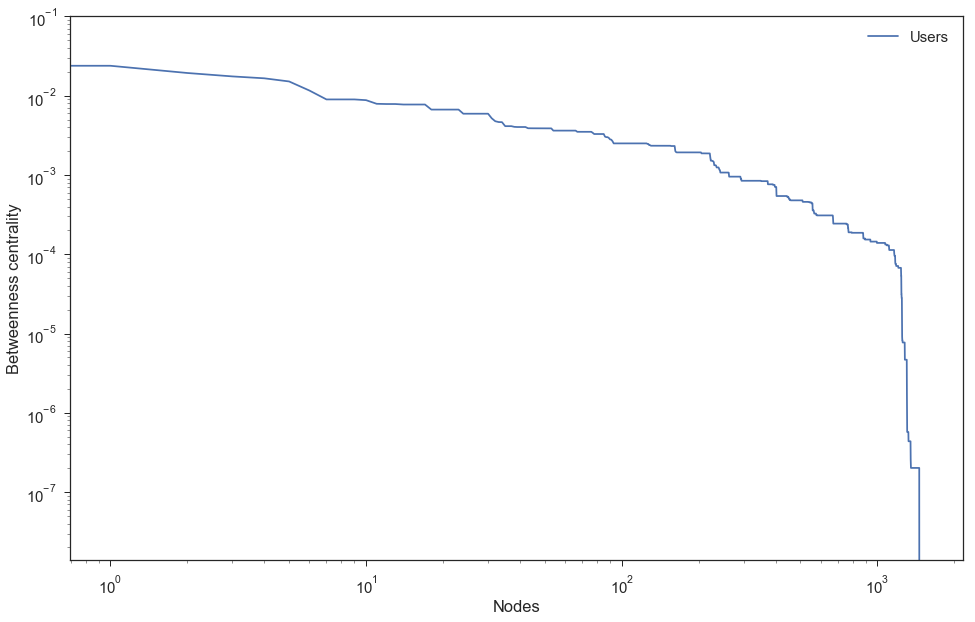

In [134]:
advanced_analysis(image)

Transitivity: 1.000
The largest component has  476 nodes accounting for 31.75 % of the nodes


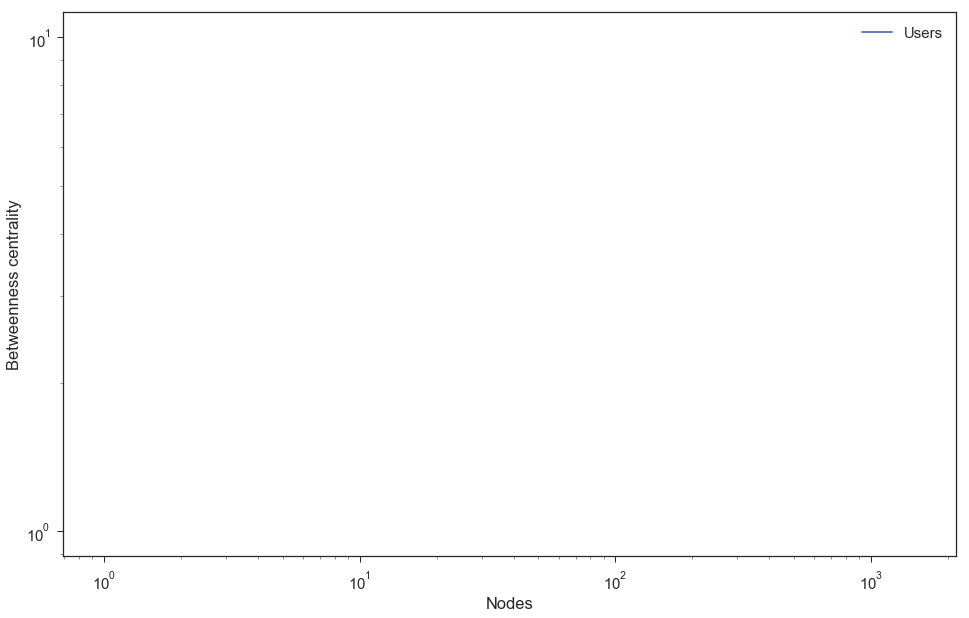

In [135]:
advanced_analysis(cc)

Transitivity: 0.895
The largest component has  1500 nodes accounting for 100.00 % of the nodes


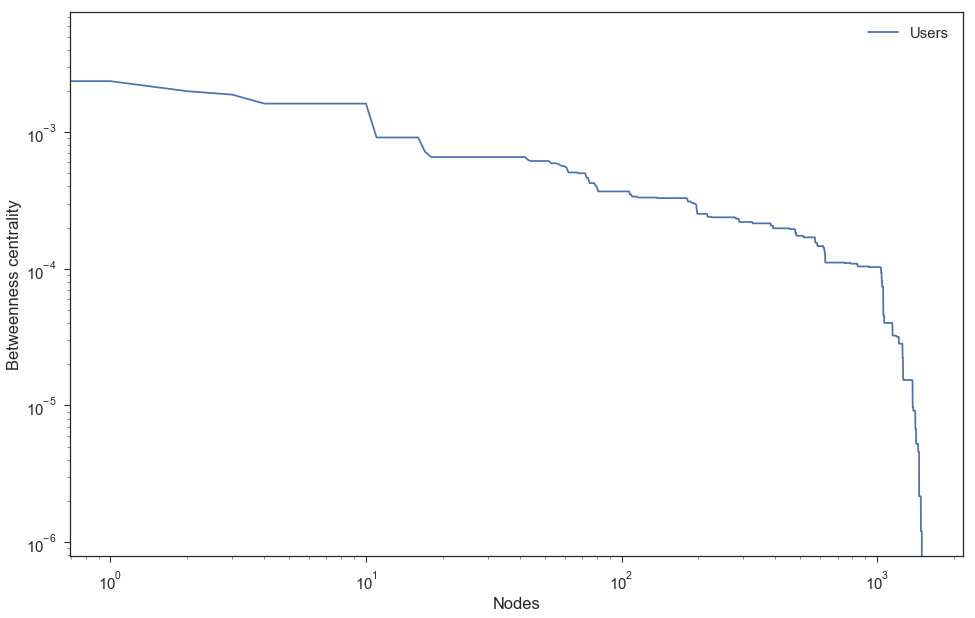

In [136]:
advanced_analysis(location)

Transitivity: 1.000
The largest component has  1359 nodes accounting for 90.60 % of the nodes


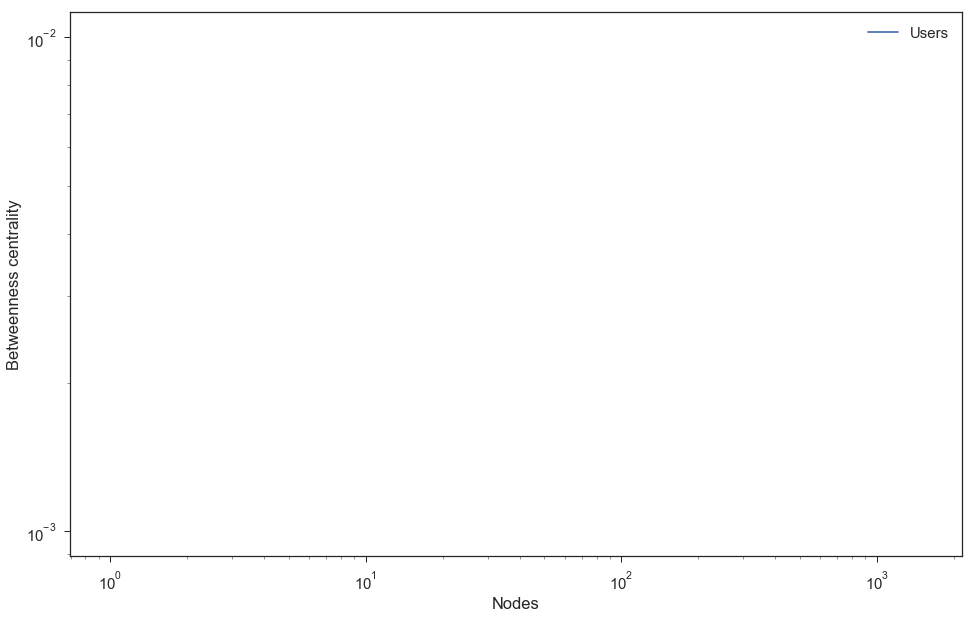

In [137]:
advanced_analysis(upload)